# CNN Practical: Inelastic Neutron Scattering

Inelastic neutron scattering (INS) can be used to infer information about the forces present in a material. Neutrons scatter off a sample, exchanging energy with certain fundamental vibrational modes of the sample. These vibraional modes include phonons (interatomic boding forces) and magnons (spin coupling between magnetic nuclei). 

[Johnstone et al. (2012)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.109.237202) have simulated magnon spectra from a double perovskite systems, where INS was used to distinguish between two possible magnetic Hamiltonians of the system. For this practical, we have simulated datasets for each of the possible Hamiltonians. We are going to train a CNN to classify the system correctly.

In [1]:
# helpers
import sys
import os
import time
import h5py
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. **Even you are not using Google Colab, please make sure you run these two cells.** 

To access the data from Google Colab, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [2]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data/'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path + 'sciml-workshop/'
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    with open('../local_data_path.txt', 'r') as f: data_path = f.read().splitlines()[0]

In [3]:
%%bash -s {google_colab_env} {colab_data_path} {bucket_name} 

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

apt -qq update
apt -qq install s3fs fuse
mkdir -p $2
s3fs $3 $2 -o allow_other,use_path_request_style,no_check_certificate,public_bucket=1,ssl_verify_hostname=0,host=https://s3.echo.stfc.ac.uk,url=https://s3.echo.stfc.ac.uk

Running notebook locally.


---

# The dataset

We have already split the data into training and validation sets and saved them into two HDF5 files, `ins-data/train.h5` and `ins-data/test.h5`, containing respectively 20,000 and 6,676 INS images and their one-hot encoded labels identifying an image as either being of the *Dimer* or *Goodenough* Hamiltonian. 

### The `torch.utils.data.Dataset` class
The number of images is so large that we may not be able to simultaneously load the whole dataset into memory on a small machine. To solve this issue, we will load the data from disk on the fly when required (at the cost of training time).

In [4]:
# define image size
from PIL import Image
import torch
from torch.utils.data import Dataset, IterableDataset, DataLoader
from torchvision import transforms as T
        
class HDF5IterableDataset(IterableDataset):
    
    def __init__(self, path, batch_size=64, image_transform=None, target_transform=None):
        super().__init__()
        
        self.path = path
        self.batch_size = batch_size
        
        self.image_transform = image_transform
        self.target_transform = target_transform
        
    def __len__(self, ):
        with h5py.File(self.path, 'r') as handle:
            n_samples = handle['images'].shape[0]
        return n_samples

    def hdf_generator(self):
        """Generator that yields batches of noisy and clean data."""
        with h5py.File(self.path, 'r') as handle:
            n_samples, h, w, c = handle['images'].shape
            for i in range(0, n_samples, self.batch_size):
                images = handle['images'][i:i + self.batch_size].astype(np.float32)
                labels = handle['labels'][i:i + self.batch_size].astype(np.float32)
                
                images = torch.from_numpy(images).permute(0, 3, 1, 2)
                
                if self.image_transform is not None:
                    images = self.image_transform(images)
        
                if self.target_transform is not None:
                    labels = self.target_transform(labels)
            
                yield images, labels

    def __iter__(self):
        """Returns an iterator over the dataset."""
        return iter(self.hdf_generator())
        
    def __getitem__(self, index):

        if self.load_h5:
            img = self.images[index].astype(np.float32)
            label = self.labels[index].astype(np.float32)
        else:
            with h5py.File(self.file_path, 'r') as handle:
                img = handle['images'][index].astype(np.float32)
                label = handle['labels'][index].astype(np.float32)

        img = torch.from_numpy(img).permute(2, 0, 1)
        
        if self.image_transform is not None:
            img = self.image_transform(img)

        if self.target_transform is not None:
            label = self.target_transform(label)

        return img, label

batch_size = 64
train_dataset = HDF5IterableDataset(data_path + 'sciml-workshop/ins-data/train.h5', batch_size=batch_size)
test_dataset = HDF5IterableDataset(data_path + 'sciml-workshop/ins-data/test.h5', batch_size=batch_size)

print("Number of training samples:", len(train_dataset))
print("Number of test samples:", len(test_dataset))

# Create dataloader to load the dataset during training
train_dataloader = DataLoader(train_dataset, batch_size=None, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=None, shuffle=False)

# Verify dataloader is working
for X, y in train_dataloader:
    print("Images:", X.shape, "Labels:", y.shape)
    break

Number of training samples: 20000
Number of test samples: 6676
Images: torch.Size([64, 1, 20, 200]) Labels: torch.Size([64, 2])


### Load and use data

In the following cell, we will load the first buffer (with 32 data by default) to memory and plot some images and labels from it:

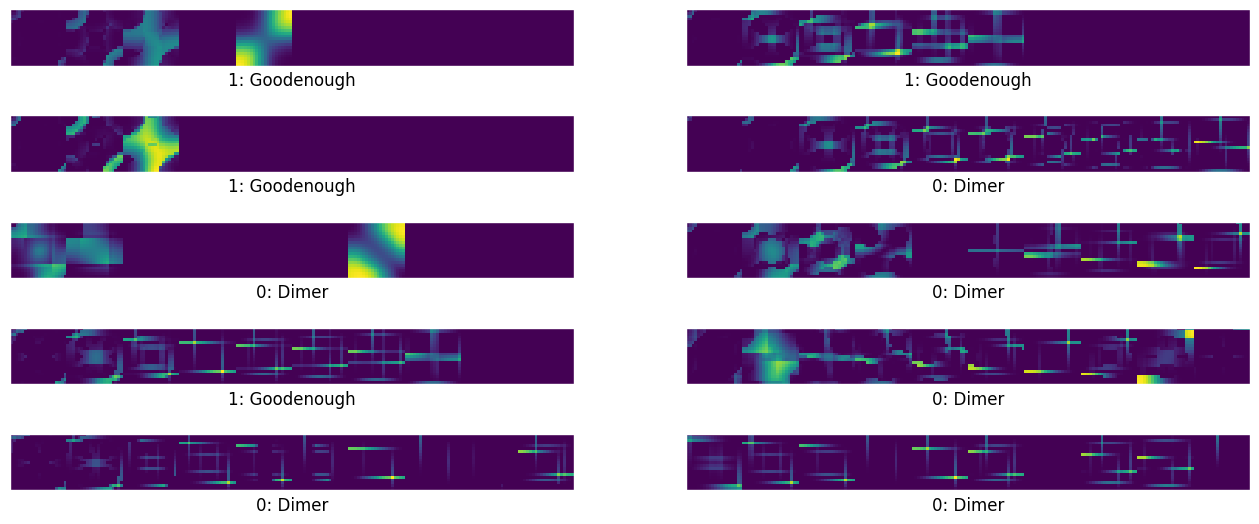

In [5]:
# load the first buffer (with 32 data by default)
images, labels = next(iter(test_dataloader))

# plot some images and labels from it
nplot = 10
fig, axes = plt.subplots(nplot // 2, 2, figsize=(16, nplot / 1.5), dpi=100)
for ax, image, label in zip(axes.flatten(), images, labels):
    ax.matshow(np.squeeze(image.numpy()))
    ax.set_xlabel('0: Dimer' if label[0] < .5 else '1: Goodenough', c='k')
    ax.set_xticks([])
    ax.set_yticks([])

# Classification by CNN

The task is to build and train a CNN to solve this binary classification problem. 

## 1. Network architecture

First, design the network architecture. Note that the image height is quite small, so we need to preserve the image size by passing `padding='same'` to `Conv2D`. A suggested architecture is provided:

- Conv2D
 - 8 filters
 - kernel size 5$\times$5
 - ReLU activation
- MaxPool2D 
- BatchNormalization
- Conv2D 
 - 16 filters
 - kernel size 3$\times$3
 - ReLU activation
- MaxPool2D
- BatchNormalization
- Conv2D 
 - 16 filters
 - kernel size 3$\times$3
 - ReLU activation
- MaxPool2D
- BatchNormalization
- Flatten 
- Dense
 - 16 units
 - ReLU activation
- Dense
 - 8 units
 - ReLU activation
- Dense
 - N classes units
 - sigmoid activation


In [6]:
import torch
from torch import nn
from torch.nn import functional as F

def conv2_layer(in_features, out_features, kernel_size, padding='same'):
    return nn.Sequential(
            nn.Conv2d(in_features, out_features, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(out_features),
        )

def mlp_layer(input_dim, output_dim, hidden_dims=[16, 8]):
    return nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], output_dim),
            nn.Sigmoid()
        )

class CNN_Model(nn.Module):
    def __init__(self, input_dim=1, output_dim=2, dropout=0.0):
        super().__init__()

        self.layer1 = conv2_layer(input_dim, 8, 5)
        self.layer2 = conv2_layer(8, 16, 3)
        self.layer3 = conv2_layer(16, 16, 3)
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        self.flatten = nn.Flatten(start_dim=1)
        
        self.mlp = mlp_layer(16, output_dim, hidden_dims=[16, 8])

    def forward(self, x):
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.mlp(x)
        
        return x

### Create and compile the model

In [7]:
# Create the model
model = CNN_Model(input_dim=1)
print(model)

# Compile the model using a dummy input with batch size 1
inputs = torch.rand((8, 1, 20, 200))
print('Inputs:', inputs.size())
outputs = model(inputs)
print('Outputs:', outputs.size())

CNN_Model(
  (layer1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mlp): Sequential(
    (

## 2.  Define loss and optimizers

In [8]:
# define loss function
loss_fn = nn.CrossEntropyLoss()

# create a optimizer with constant learning rate of 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## 3. Train the model

Using the suggested architecture, we can achieve an accuracy greater than 95% with 2 epochs. 


In [9]:
# define a train function
def train(dataloader, model, loss_fn, optimizer, device):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    
    train_loss, train_accuracy = 0, 0
    for batch, (X, y) in enumerate(dataloader):

        # place tensors to device
        X, target_y = X.to(device), y.to(device)

        # Forward pass 
        pred_y = model(X)

        # compute loss
        loss = loss_fn(pred_y, target_y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_accuracy += (pred_y.argmax(1) == target_y.argmax(1)).type(torch.float).sum().item()
        train_loss += loss.detach().item()
    
    train_loss /= num_batches
    train_accuracy /= size
    
    return train_loss, train_accuracy

# define a test function to evaluate the model
def test(dataloader, model, loss_fn, device):
    # set the model to eval mode
    model.eval()
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, target_y = X.to(device), y.to(device)
            
            # inference/prediction
            pred_y = model(X)

            # compute test loss and accuracy
            test_loss += loss_fn(pred_y, target_y).item()
            test_accuracy += (pred_y.argmax(1) == target_y.argmax(1)).type(torch.float).sum().item()
            
    test_loss /= num_batches
    test_accuracy /= size

    return test_loss, test_accuracy

def trainer(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device):
    
    start = time.time()
    
    h = dict(train_loss=[], test_loss=[], train_accuracy=[], test_accuracy=[])
    
    for t in range(epochs):
        print(f"\nEpoch {t+1}/{epochs}: ", end='')
        
        train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer, device)

        test_loss, test_accuracy = test(test_dataloader, model, loss_fn, device)
        print(f"train_loss: {train_loss:0.3f}, train_accuracy: {(100*train_accuracy):0.2f}%, test_accuracy: {(100*test_accuracy):0.2f}%")

        # print(f"Test Accuracy: {(100*test_accuracy):0.2f}%, Test Loss: {test_loss:0.3f}")

        h['train_loss'].append(train_loss)
        h['test_loss'].append(test_loss)
        h['train_accuracy'].append(train_accuracy)
        h['test_accuracy'].append(test_accuracy)

    print(f"Done in {time.time()-start:.3f}secs!")
    
    return h

epochs = 20

# Run the training on GPU if available 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CNN_Model(input_dim=1).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history = trainer(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device)


Epoch 1/20: 

/home/ubuntu/miniconda3/envs/sciml-workshop/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


train_loss: 0.009, train_accuracy: 77.44%, test_accuracy: 90.38%

Epoch 2/20: train_loss: 0.006, train_accuracy: 92.59%, test_accuracy: 94.28%

Epoch 3/20: train_loss: 0.006, train_accuracy: 94.98%, test_accuracy: 91.58%

Epoch 4/20: train_loss: 0.006, train_accuracy: 95.94%, test_accuracy: 94.40%

Epoch 5/20: train_loss: 0.005, train_accuracy: 96.21%, test_accuracy: 94.05%

Epoch 6/20: train_loss: 0.005, train_accuracy: 96.49%, test_accuracy: 95.96%

Epoch 7/20: train_loss: 0.005, train_accuracy: 97.31%, test_accuracy: 96.63%

Epoch 8/20: train_loss: 0.005, train_accuracy: 97.48%, test_accuracy: 96.38%

Epoch 9/20: train_loss: 0.005, train_accuracy: 97.27%, test_accuracy: 95.45%

Epoch 10/20: train_loss: 0.005, train_accuracy: 97.45%, test_accuracy: 96.24%

Epoch 11/20: train_loss: 0.005, train_accuracy: 97.19%, test_accuracy: 97.35%

Epoch 12/20: train_loss: 0.005, train_accuracy: 97.45%, test_accuracy: 95.78%

Epoch 13/20: train_loss: 0.005, train_accuracy: 97.79%, test_accuracy: 93

## 4. More exercises

If you have completed all of these exercises, you may like to return to the [CNN_basics.ipynb](CNN_basics.ipynb) notebook and attempt some of the exercises there.